# Problem Statement

The large company who is into beverages business in Australia. They sell their products through various super-markets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed forecast of each of products at item level every week in weekly buckets.

# Objective

1. Build at least 4-5 multivariable forecasting model which included ML or Deep Learning based Model in PySpark leveraging parallel computing techniques.

2. Demonstrate best in class forecast accuracy (Forecast Accuracy = 1 - Wt. MAPE where Wt. MAPE = sum(Error)/sum(Actual).

3. Write a code in such a way you run the model in least time.

4. Demonstrate explainability in the form of contribution of each variables

5. Leveage Feature Engineering concepts to derive more variables to gain accuracy improvement


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/papitaAlgodonCplusplus/LISUM24/main/Week%207/Datatset/forecasting_case_study.csv')

# Dataset Raw Visualization

In [ ]:
df

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.00,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.00,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.00,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.00,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1213,SKU6,10/18/2020,96619,54%,0,1,0,-7.56,1,0,0,0
1214,SKU6,10/25/2020,115798,52%,0,1,0,-8.39,1,0,0,0
1215,SKU6,11/1/2020,152186,54%,1,0,1,-7.43,1,0,0,0
1216,SKU6,11/8/2020,26445,44%,1,0,1,-5.95,1,0,0,0


# Features


* **Product:** X Product that the company offers to their clients

* **Date:** *Month - Day - Year* where row X transactions ocurred

* **Sales:** Number of products X sold that day

* **Price Discount (%):** Discount applied to the product X that day

* **In-Store Promo:** Wheter there was promotion of that product indoors or not

* **Catalogue Promo:** Wheter there was promotion of that product in the catalogue or not

* **Store End Promo:** Wheter there was promotion of that product outdoors or not

* **Google_Mobility:** Google Mobility, also known as Google COVID-19 Community Mobility Reports, is a data initiative launched by Google to provide insights into how people's movements and activities have changed in response to the COVID-19 pandemic, this as a feature column with ranges [-inf, inf] means wheter X product sales during Y date were supossed to change or not, and by how much.

* **Covid_Flag:** A binary column that only activates when google mobility predicts changes on sales of X product during Y date.

* **V_DAY:** Wheter that day was Valentine's day for the company or not

* **Easter:** Wheter that day was Easter for the company or not

* **Christmas:** Wheter that day was Christmas for the company or not

# Data types

**Categorical Data:**
- Product: X Product that the company offers to their clients

**Continuous Numerical Data:**
- Date: Month - Day - Year where row X transactions occurred (If changed to another analogous format)
- Sales: Number of products X sold that day
- Price Discount (%): Discount applied to product X that day
- Google_Mobility: Google Mobility index indicating the change in sales due to the COVID-19 pandemic (ranges [-inf, inf])

**Binary Data:**
- In-Store Promo: Whether there was an indoor promotion of that product or not
- Catalogue Promo: Whether there was a promotion of that product in the catalogue or not
- Store End Promo: Whether there was an outdoor promotion of that product or not
- Covid_Flag: A binary column that activates when Google Mobility predicts changes in sales of X product during Y date
- V_DAY: Whether that day was Valentine's day for the company or not
- Easter: Whether that day was Easter for the company or not
- Christmas: Whether that day was Christmas for the company or not

# Data preprocessing

## NA values

<font color= 'purple'>**Approach:**</font> First let's see if there are any NA values to handle, if so, either mean or mode could be applied.

In [ ]:
na_counts = df.isna().sum()

for column, na_count in na_counts.items():
    print(f"{column}: {na_count}")

Product: 0
date: 0
Sales: 0
Price Discount (%): 0
In-Store Promo: 0
Catalogue Promo: 0
Store End Promo: 0
Google_Mobility: 0
Covid_Flag: 0
V_DAY: 0
EASTER: 0
CHRISTMAS: 0


## Outliers

In [ ]:
def plot_data(df, column, sort=False, x=None):
  if sort:
    sorted_df = df.sort_values(by=column)
    plt.plot(sorted_df[column], sorted_df[x])
    plt.title('Sorted: '+ column + ' by ' + x)
    plt.xlabel(x)
    plt.ylabel(column)
    plt.show()

  else:
    # Plotting numerical column
    plt.figure(figsize=(10, 6))
    if x != None:
      plt.scatter(df[column], df[x])
      plt.xlabel(column)
      plt.ylabel(x)
      plt.title('Scatter Plot')
      plt.show()
    else:
      plt.plot(df[column])
      plt.title(column)
      plt.show()

def delete_noise(df, column, reduction_method='IQR', error_margin=1.5, plot_noise=True, threshold=4, renew=True):
  if reduction_method == 'IQR':
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - error_margin * IQR
    upper_bound = Q3 + error_margin * IQR

    noisy_indices = (df[column] < lower_bound) | (df[column] > upper_bound)

    if plot_noise:
      df['Is_Noisy'] = noisy_indices

      plt.figure(figsize=(10, 6))
      plt.scatter(df.index, df[column], c=df['Is_Noisy'], cmap='coolwarm', marker='o')
      plt.title('Identified Outliers')
      plt.colorbar(label='Outlier (1) / Non-outlier (0)')
      plt.show()

      df.drop('Is_Noisy', axis=1, inplace=True)

    if renew:
      return df.drop(df.index[noisy_indices]).copy()

  if reduction_method == 'Statistical':
    mean = df[column].mean()
    std_dev = df[column].std()

    noise_threshold = mean + threshold * std_dev
    noisy_indices = (df[column] - mean).abs() > threshold * std_dev

    if plot_noise:
      df['Is_Noisy'] = noisy_indices

      plt.figure(figsize=(10, 6))
      plt.scatter(df.index, df[column], c=df['Is_Noisy'], cmap='coolwarm', marker='o')
      plt.title('Identified Outliers')
      plt.colorbar(label='Outlier (1) / Non-outlier (0)')
      plt.show()

      df.drop('Is_Noisy', axis=1, inplace=True)

    if renew:
      return df[df[column] <= noise_threshold]

### Google Mobility

#### Stadistical Method

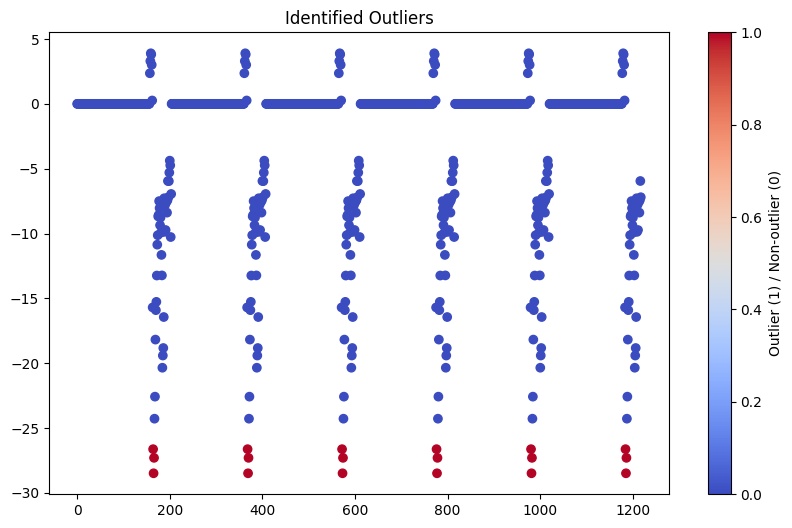

In [ ]:
test_df = delete_noise(df, 'Google_Mobility', reduction_method='Statistical')

#### IQR Method

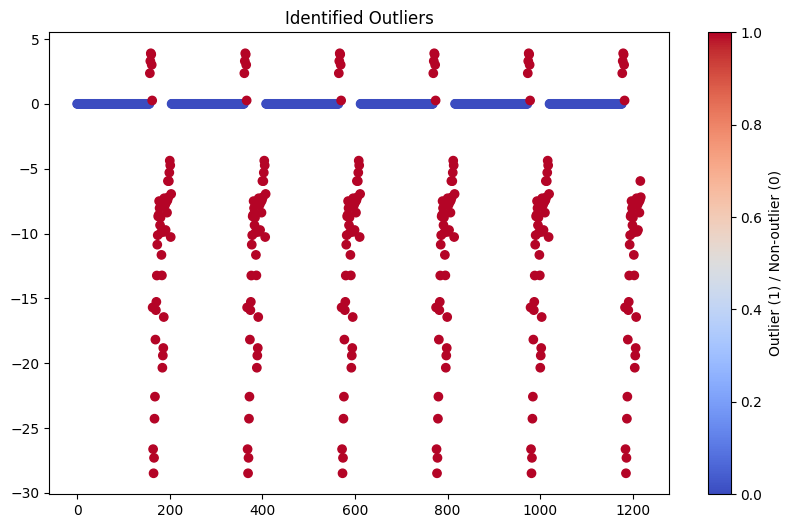

In [ ]:
test_df = delete_noise(df, 'Google_Mobility')

#### Am I deleting outliners?

<font color='red'>**Discarded:**</font> Because the outliers are actually a pattern and is not greater than 30% decrease prediction (which is lucid in the context of COVID)

### Discount

#### Stadistical Method

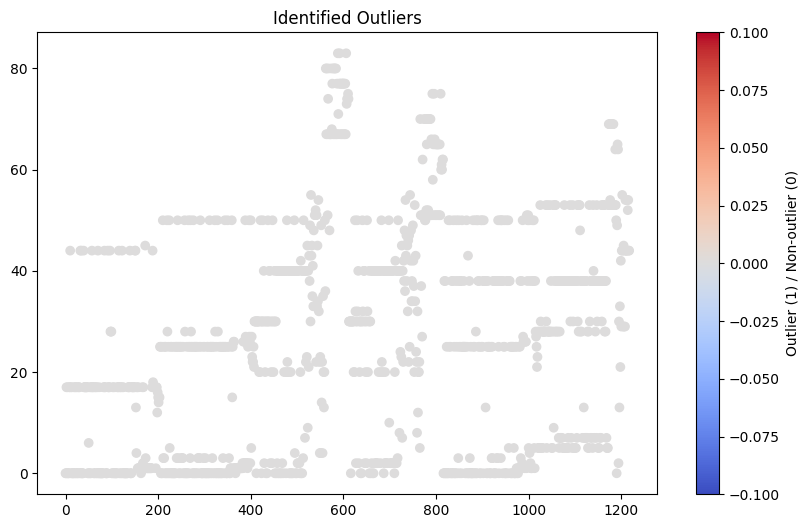

In [ ]:
df['Price Discount (%)'] = df['Price Discount (%)'].str.replace('%', '').astype(float)
test_df = delete_noise(df, 'Price Discount (%)', reduction_method='Statistical')

#### IQR Method

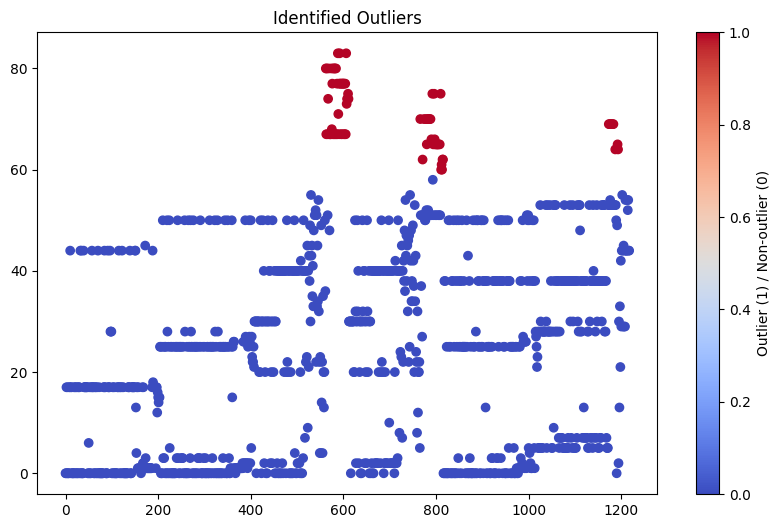

In [ ]:
test_df = delete_noise(df, 'Price Discount (%)', error_margin=0.5)

#### Am I deleting outliners?

<font color='red'>**Discarded:**</font> Because the outliers % of discount are  common in the context of this company's timeline given some season and acceptation would only generate weights misplacement later on model training and tuning.

With this, outlier detection is concluded, as there is no binary noise to delete statistically and 'Sales' is the label/target, not a feature.

## Skewed Data

### Google Mobility Normalization

<font color='green'>**Accepted:**</font> Normalization helps to ensure faster convergence and prevents biased magnitude domination during training.

<font color= 'purple'>**Approach:**</font> First step is to create a function to fastly plot the resulting values of the normalized columns, then, normalization is applied.

In [ ]:
import plotly.graph_objects as go

def plot(df, *columns, title=""):
    fig = go.Figure()

    for column in columns:
        fig.add_trace(go.Scatter(y=df[column], mode='lines+markers', name=column, opacity=0.7))

    fig.update_layout(
        xaxis_title="Index",
        yaxis_title="Value",
        title=title,
    )

    fig.show()

plot(df, 'Google_Mobility')

In [ ]:
min = df['Google_Mobility'].min()
max = df['Google_Mobility'].max()

df['Google_Mobility'] = (df['Google_Mobility'] - min) / (max - min)

plot(df, 'Google_Mobility')

### Google_Mobility logarithmic transformation

In [ ]:
test_df['Google_Mobility'] = np.log1p(df['Google_Mobility'])
plot(test_df, 'Google_Mobility')

<font color='red'>**Discarded:**</font> Logarithmic transformation has no effect on this column (neither price discount) because the trend stays still to the end.

### Price Discount (%) Normalization

In [ ]:
plot(df, 'Price Discount (%)')

In [ ]:
min = df['Price Discount (%)'].min()
max = df['Price Discount (%)'].max()

df['Price Discount (%)'] = (df['Price Discount (%)'] - min) / (max - min)

plot(df, 'Price Discount (%)')

## Date Encoding

<font color='green'>**Accepted:**</font> Encoding 'date' column is necessary so the chosen model can make forecast predictions over seasonality patterns.

<font color= 'purple'>**Approach:**</font> Using the datetime option from pandas, is easy to extract year, month and day for each row into new columns

In [ ]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

## Aggregation for Time Analysis

<font color='green'>**Accepted:**</font> Aggregating the whole dataframe to obtain 2 new datasets based on year and month could be beneficial both for EDA and Training.

<font color= 'purple'>**Approach:**</font> First step is grouping the dataframe by month or year, apply aggregation based on 4 columns selected to EDA:

1. Sales by it's total sum over the month/year
2. Discount as the standard deviation it had during the month/year
3. Google Mobility by it's mean value during the month/year
4. Product by creating 6 different aggregated dataframes

### By month

In [ ]:
df_sku1 = df[df['Product'] == 'SKU1']
df_sku2 = df[df['Product'] == 'SKU2']
df_sku3 = df[df['Product'] == 'SKU3']
df_sku4 = df[df['Product'] == 'SKU4']
df_sku5 = df[df['Product'] == 'SKU5']
df_sku6 = df[df['Product'] == 'SKU6']

def aggregate(df, target):
  local_df = df.groupby(df['date'].dt.to_period(target)).agg({
      'Sales': 'sum',
      'Price Discount (%)': 'std',
      'Google_Mobility': 'mean',
      'Product': 'count'
  }).reset_index()
  return local_df

monthly_aggregated_sku1 = aggregate(df_sku1, 'M')
monthly_aggregated_sku2 = aggregate(df_sku2, 'M')
monthly_aggregated_sku3 = aggregate(df_sku3, 'M')
monthly_aggregated_sku4 = aggregate(df_sku4, 'M')
monthly_aggregated_sku5 = aggregate(df_sku5, 'M')
monthly_aggregated_sku6 = aggregate(df_sku6, 'M')
plot(monthly_aggregated_sku3, 'Sales')

### By year

In [ ]:
yearly_aggregated_sku1 = aggregate(df_sku1, 'Y')
yearly_aggregated_sku2 = aggregate(df_sku2, 'Y')
yearly_aggregated_sku3 = aggregate(df_sku3, 'Y')
yearly_aggregated_sku4 = aggregate(df_sku4, 'Y')
yearly_aggregated_sku5 = aggregate(df_sku5, 'Y')
yearly_aggregated_sku6 = aggregate(df_sku6, 'Y')

plot(yearly_aggregated_sku6, 'Product')

This concludes data preprocessing, now all the data is normalized and has no issues to resolve before entering training stage.

# EDA & Feature Analysis

## Feature Engineering

### Lag Period Difference (A.K.A Derivative Function)

This will return a column with the difference or change ratio of the sales values based on the previous sale.

#### Global Dataframe

In [ ]:
import plotly.express as px

df_sorted_date = df.sort_values(by='date')
df_sorted_date = df_sorted_date.reset_index(drop=True)

shifted_sales = df_sorted_date['Sales'].shift(1)
df_sorted_date['Change_Ratio'] = df_sorted_date['Sales'] - shifted_sales

fig = px.line(df_sorted_date, x=df_sorted_date.index, y=['Sales', 'Change_Ratio'],
              labels={'x': 'Date', 'y': 'Sales'},
              title='Sales and Change Ratio')

fig.show()

#### Monthly Dataframe

In [ ]:
monthly_dfs = [monthly_aggregated_sku1, monthly_aggregated_sku2, monthly_aggregated_sku3, monthly_aggregated_sku4,
               monthly_aggregated_sku5, monthly_aggregated_sku6]

for idx, dataframe in enumerate(monthly_dfs):
    shifted_sales = dataframe['Sales'].shift(1)
    dataframe['Change_Ratio'] = dataframe['Sales'] - shifted_sales
    monthly_dfs[idx] = dataframe

combined_df = pd.concat([dataframe['Change_Ratio'] for dataframe in monthly_dfs], axis=1)
combined_df.columns = [f"SKU{idx+1}" for idx in range(len(monthly_dfs))]
combined_df.dropna(inplace=True)

fig = px.line(combined_df, x=combined_df.index, y=combined_df.columns, title='Change Ratio for SKUs')
fig.show()

#### Yearly Dataframe

In [ ]:
yearly_dfs = [yearly_aggregated_sku1, yearly_aggregated_sku2, yearly_aggregated_sku3,
              yearly_aggregated_sku4, yearly_aggregated_sku5, yearly_aggregated_sku6]

for idx, dataframe in enumerate(yearly_dfs):
    shifted_sales = dataframe['Sales'].shift(1)
    dataframe['Change_Ratio'] = dataframe['Sales'] - shifted_sales
    yearly_dfs[idx] = dataframe

combined_df = pd.concat([dataframe['Change_Ratio'] for dataframe in yearly_dfs], axis=1)
combined_df.columns = [f"SKU{idx+1}" for idx in range(len(yearly_dfs))]
combined_df.dropna(inplace=True)

fig = px.line(combined_df, x=combined_df.index, y=combined_df.columns, title='Change Ratio for SKUs (Yearly)')
fig.show()

### Rolling Average

This will return a mathematical insight of the sales trend

#### Sales

###### Weekly

In [ ]:
df_sorted_date['Rolling_Avg'] = df_sorted_date['Sales'].rolling(window=7).mean()
plot(df_sorted_date, 'Rolling_Avg', 'Sales')
df_sorted_date.drop('Rolling_Avg', axis=1, inplace=True)

In [ ]:
df_sorted_date['Rolling_Avg'] = df_sorted_date['Sales'].rolling(window=7).mean()

min = df_sorted_date['Rolling_Avg'].min()
max = df_sorted_date['Rolling_Avg'].max()

df_sorted_date['Rolling_Avg'] = (df_sorted_date['Rolling_Avg'] - min) / (max - min)

min = df_sorted_date['Sales'].min()
max = df_sorted_date['Sales'].max()

df_sorted_date['Sales_Norm'] = (df_sorted_date['Sales'] - min) / (max - min)

plot(df_sorted_date, 'Rolling_Avg', 'Sales_Norm', 'Google_Mobility')
df_sorted_date.drop('Rolling_Avg', axis=1, inplace=True)
df_sorted_date.drop('Sales_Norm', axis=1, inplace=True)

We can see Google Mobility has not any important impact over sales raw data nor tendency

##### Log Weekly

In [ ]:
df_sorted_date['Rolling_Avg'] = df_sorted_date['Sales'].rolling(window=7).mean()
df_sorted_date['Rolling_Avg'] = np.log1p(df_sorted_date['Rolling_Avg'])
df_sorted_date['Sales_Log'] = np.log1p(df_sorted_date['Sales'])
plot(df_sorted_date, 'Rolling_Avg', 'Sales_Log')
df_sorted_date.drop('Rolling_Avg', axis=1, inplace=True)
df_sorted_date.drop('Sales_Log', axis=1, inplace=True)

##### Monthly

In [ ]:
df_sorted_date['Rolling_Avg'] = df_sorted_date['Sales'].rolling(window=30).mean()
plot(df_sorted_date, 'Rolling_Avg', 'Sales')
df_sorted_date.drop('Rolling_Avg', axis=1, inplace=True)

In [ ]:
df_sorted_date['Rolling_Avg'] = df_sorted_date['Sales'].rolling(window=30).mean()

min = df_sorted_date['Rolling_Avg'].min()
max = df_sorted_date['Rolling_Avg'].max()

df_sorted_date['Rolling_Avg'] = (df_sorted_date['Rolling_Avg'] - min) / (max - min)

min = df_sorted_date['Sales'].min()
max = df_sorted_date['Sales'].max()

df_sorted_date['Sales_Norm'] = (df_sorted_date['Sales'] - min) / (max - min)
df_sorted_date['Discount_Mean'] = df_sorted_date['Price Discount (%)'].rolling(window=15).mean()

plot(df_sorted_date, 'Rolling_Avg', 'Sales_Norm', 'Discount_Mean')
df_sorted_date.drop('Rolling_Avg', axis=1, inplace=True)
df_sorted_date.drop('Sales_Norm', axis=1, inplace=True)
df_sorted_date.drop('Discount_Mean', axis=1, inplace=True)

There is actually some mild patterns between the monthly rolling average of sales and biweekly discount.

##### Log Monthly

In [ ]:
df_sorted_date['Rolling_Avg'] = df_sorted_date['Sales'].rolling(window=30).mean()
df_sorted_date['Rolling_Avg'] = np.log1p(df_sorted_date['Rolling_Avg'])
df_sorted_date['Sales_Log'] = np.log1p(df_sorted_date['Sales'])
plot(df_sorted_date, 'Rolling_Avg', 'Sales_Log')
df_sorted_date.drop('Rolling_Avg', axis=1, inplace=True)
df_sorted_date.drop('Sales_Log', axis=1, inplace=True)

#### In-Store Promotion Lag Effects

This will calculate and plot the amount of "lag" or "impact" 1 day of in-store promotion has over sales, e.g. promotion during 14 February has sales increase during 14, 15, 16 and 17 of February.

##### SKU 1

In [ ]:
fig = go.Figure()

df_sku1_total = df[df['Product'] == 'SKU1']

fig.add_trace(go.Scatter(x=df_sku1_total['date'], y=df_sku1_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku1_total.iterrows():
    if row['In-Store Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku1_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 40K

##### SKU 2

In [ ]:
fig = go.Figure()

df_sku2_total = df[df['Product'] == 'SKU2']

fig.add_trace(go.Scatter(x=df_sku2_total['date'], y=df_sku2_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku2_total.iterrows():
    if row['In-Store Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku2_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'today's' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 30K

##### SKU 3

In [ ]:
fig = go.Figure()

df_sku3_total = df[df['Product'] == 'SKU3']

fig.add_trace(go.Scatter(x=df_sku3_total['date'], y=df_sku3_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku3_total.iterrows():
    if row['In-Store Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku3_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 50K

##### SKU 4

In [ ]:
fig = go.Figure()

df_sku4_total = df[df['Product'] == 'SKU4']

fig.add_trace(go.Scatter(x=df_sku4_total['date'], y=df_sku4_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku4_total.iterrows():
    if row['In-Store Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku4_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'today's' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 10K

##### SKU 5

In [ ]:
fig = go.Figure()

df_sku5_total = df[df['Product'] == 'SKU5']

fig.add_trace(go.Scatter(x=df_sku5_total['date'], y=df_sku5_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku5_total.iterrows():
    if row['In-Store Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku5_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'today's' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 20K

##### SKU 6

In [ ]:
fig = go.Figure()

df_sku6_total = df[df['Product'] == 'SKU6']

fig.add_trace(go.Scatter(x=df_sku6_total['date'], y=df_sku6_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku6_total.iterrows():
    if row['In-Store Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku6_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is not a pattern between promotion and sales.

#### Catalogue Lag Effects

This will calculate and plot the amount of "lag" or "impact" 1 day of catalogue promotion has over sales, e.g. promotion during 14 February has sales increase during 14, 15, 16 and 17 of February.

##### SKU 1

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku1_total['date'], y=df_sku1_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku1_total.iterrows():
    if row['Catalogue Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku1_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between '4-5 days' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 40K

##### SKU 2

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku2_total['date'], y=df_sku2_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku2_total.iterrows():
    if row['Catalogue Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku2_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 30K

##### SKU 3

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku3_total['date'], y=df_sku3_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku3_total.iterrows():
    if row['Catalogue Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku3_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 50K

##### SKU 4

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku4_total['date'], y=df_sku4_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku4_total.iterrows():
    if row['Catalogue Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku4_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 10K

##### SKU 5

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku5_total['date'], y=df_sku5_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku5_total.iterrows():
    if row['Catalogue Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku5_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 20K

##### SKU 6

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku6_total['date'], y=df_sku6_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku6_total.iterrows():
    if row['Catalogue Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku6_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 20K

#### Store-End Lag Effects

This will calculate and plot the amount of "lag" or "impact" 1 day of store-end promotion has over sales, e.g. promotion during 14 February has sales increase during 14, 15, 16 and 17 of February.

##### SKU 1

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku1_total['date'], y=df_sku1_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku1_total.iterrows():
    if row['Store End Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku1_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is a mild correlation between '1-2 days' it most of the time have a promotion the day before sales where up to >= 40K

##### SKU 2

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku2_total['date'], y=df_sku2_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku2_total.iterrows():
    if row['Store End Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku2_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a semi-strong correlation between 'yesterday' promotion and 'today's' sales, it does have 90% of the time a promotion the day before sales where up to >= 30K

##### SKU 3

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku3_total['date'], y=df_sku3_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku3_total.iterrows():
    if row['Store End Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku3_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'today's' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 50K

##### SKU 4

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku4_total['date'], y=df_sku4_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku4_total.iterrows():
    if row['Store End Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku4_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

No correlation found

##### SKU 5

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku5_total['date'], y=df_sku5_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku5_total.iterrows():
    if row['Store End Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku5_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is actually a strong correlation between 'yesterday' promotion and 'today's' sales, almost making it impossible to not have a promotion the day before sales where up to >= 20K

##### SKU 6

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sku6_total['date'], y=df_sku6_total['Sales'], mode='lines', name='Sales'))

for index, row in df_sku6_total.iterrows():
    if row['Store End Promo'] == 1:
        fig.add_shape(
            type="rect",
            x0=row['date'],
            x1=row['date'],
            y0=0,
            y1=df_sku6_total['Sales'].max(),
            line=dict(color="red"),
        )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Sales",
    title="Sales Trend with Promotion Periods",
)

fig.show()

There is a weak correlation between 'yesterday' promotion and 'today's' sales, it sometimes have a promotion the day before sales where up to >= 20K

## Sales by Date and Product

In [ ]:
unique_products = df['Product'].unique()

fig = go.Figure()

for product in unique_products:
    product_data = df[df['Product'] == product]
    fig.add_trace(go.Scatter(
        x=product_data['date'],
        y=product_data['Sales'],
        mode='lines+markers',
        name=product
    ))

fig.update_layout(
    title="Sales Over Time by Product",
    xaxis_title="Date",
    yaxis_title="Sales",
    xaxis=dict(type='date')
)

fig.show()

Products don't seem to have any correlation between them in terms of sales

## Product Count

In [ ]:
import plotly.express as px

fig = px.bar(df, x='Product', color='Product', title='Product Sales')

fig.show()

All products are equally sold by an amount of 200 rounded

## Product Sales

In [ ]:
fig = px.bar(df, x='Product', y='Sales', color='Product', title='Product Sales')

fig.show()

In order, the profit by product would be: SKU3, SKU1, SKU6, SKU4, SKU5 and SKU2, as Pie Plot:

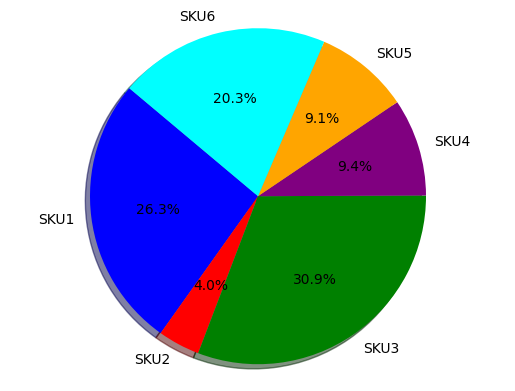

In [ ]:
labels = df['Product'].unique()
sku_sums = {}

for sku in labels:
    sku_sum = df[df['Product'] == sku]['Sales'].sum()
    sku_sums[sku] = sku_sum

sizes = [sku_sums[sku] for sku in labels]

colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

## Probability Distribution | Sales over Product

In [ ]:
from plotly.colors import n_colors

grouped_df = df.groupby('Product')['Sales'].apply(list).reset_index()

colors = n_colors('rgb(255, 40, 40)', 'rgb(255, 255, 10)', 12, colortype='rgb')

fig = go.Figure()
for data_line, day_name, color in zip(grouped_df['Sales'], grouped_df['Product'], colors):
    fig.add_trace(go.Violin(x=data_line, line_color=color, name=day_name))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

### Confidence Intervals

In [ ]:
def bootstrap_mean(data, n_bootstrap=1000, alpha=0.05):
    bootstrap_means = []
    n_samples = len(data)

    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n_samples, replace=True)
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    lower_ci = np.percentile(bootstrap_means, 100 * alpha / 2)
    upper_ci = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
    return lower_ci, upper_ci

In [ ]:
sku1_ci_lower, sku1_ci_upper = bootstrap_mean(df_sku1_total['Sales'])
sku2_ci_lower, sku2_ci_upper = bootstrap_mean(df_sku2_total['Sales'])
sku3_ci_lower, sku3_ci_upper = bootstrap_mean(df_sku3_total['Sales'])
sku4_ci_lower, sku4_ci_upper = bootstrap_mean(df_sku4_total['Sales'])
sku5_ci_lower, sku5_ci_upper = bootstrap_mean(df_sku5_total['Sales'])
sku6_ci_lower, sku6_ci_upper = bootstrap_mean(df_sku6_total['Sales'])

print("Confidence Intervals for Sales over Product:")
print(f"SKU1: [{sku1_ci_lower:.2f}, {sku1_ci_upper:.2f}]")
print(f"SKU2: [{sku2_ci_lower:.2f}, {sku2_ci_upper:.2f}]")
print(f"SKU3: [{sku3_ci_lower:.2f}, {sku3_ci_upper:.2f}]")
print(f"SKU4: [{sku4_ci_lower:.2f}, {sku4_ci_upper:.2f}]")
print(f"SKU5: [{sku5_ci_lower:.2f}, {sku5_ci_upper:.2f}]")
print(f"SKU6: [{sku6_ci_lower:.2f}, {sku6_ci_upper:.2f}]")

Confidence Intervals for Sales over Product:
SKU1: [43574.16, 52112.24]
SKU2: [6107.43, 8654.14]
SKU3: [49403.63, 63337.02]
SKU4: [14931.67, 19247.07]
SKU5: [14460.09, 18752.23]
SKU6: [32916.42, 43159.34]


## Probability Distribution | Discount over Product

In [ ]:
from plotly.colors import n_colors

grouped_df = df.groupby('Product')['Price Discount (%)'].apply(list).reset_index()

for i in range(0,5):
  grouped_df.iloc[i,1].sort()

colors = n_colors('rgb(20, 150, 40)', 'rgb(20, 255, 255)', 12, colortype='rgb')

fig = go.Figure()
for data_line, day_name, color in zip(grouped_df['Price Discount (%)'], grouped_df['Product'], colors):
    fig.add_trace(go.Violin(x=data_line, line_color=color, name=day_name))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

### Confidence Intervals

In [ ]:
sku1_ci_lower, sku1_ci_upper = bootstrap_mean(df_sku1_total['Price Discount (%)'])
sku2_ci_lower, sku2_ci_upper = bootstrap_mean(df_sku2_total['Price Discount (%)'])
sku3_ci_lower, sku3_ci_upper = bootstrap_mean(df_sku3_total['Price Discount (%)'])
sku4_ci_lower, sku4_ci_upper = bootstrap_mean(df_sku4_total['Price Discount (%)'])
sku5_ci_lower, sku5_ci_upper = bootstrap_mean(df_sku5_total['Price Discount (%)'])
sku6_ci_lower, sku6_ci_upper = bootstrap_mean(df_sku6_total['Price Discount (%)'])

print("Confidence Intervals for Price Discount (%) over Product:")
print(f"SKU1: [{sku1_ci_lower:.2f}, {sku1_ci_upper:.2f}]")
print(f"SKU2: [{sku2_ci_lower:.2f}, {sku2_ci_upper:.2f}]")
print(f"SKU3: [{sku3_ci_lower:.2f}, {sku3_ci_upper:.2f}]")
print(f"SKU4: [{sku4_ci_lower:.2f}, {sku4_ci_upper:.2f}]")
print(f"SKU5: [{sku5_ci_lower:.2f}, {sku5_ci_upper:.2f}]")
print(f"SKU6: [{sku6_ci_lower:.2f}, {sku6_ci_upper:.2f}]")

Confidence Intervals for Price Discount (%) over Product:
SKU1: [0.11, 0.15]
SKU2: [0.14, 0.19]
SKU3: [0.42, 0.50]
SKU4: [0.39, 0.46]
SKU5: [0.22, 0.28]
SKU6: [0.36, 0.42]


## Correlation Heatmap | Holidays

A heatmap over the mean effect holidays have over the change ratio of the sales of each product

In [ ]:
min = df_sorted_date['Change_Ratio'].min()
max = df_sorted_date['Change_Ratio'].max()

df_sorted_date['Change_Ratio_Norm'] = (df_sorted_date['Change_Ratio'] - min) / (max - min) * 2 - 1

pivot_df = df_sorted_date.pivot_table(index='Product', columns=['V_DAY', 'EASTER', 'Covid_Flag', 'CHRISTMAS'], values='Change_Ratio_Norm', aggfunc='mean')
x_binary_columns = ['V_DAY', 'EASTER', 'Covid_Flag', 'CHRISTMAS']
pivot_df = pivot_df.dropna(axis=1)

y_product_categories = pivot_df.index.tolist()

heatmap = go.Figure(data=go.Heatmap(
    z=pivot_df.values,
    x=x_binary_columns,
    y=y_product_categories,
    colorscale='Viridis'))

heatmap.update_layout(
    title='Sales Heatmap',
    xaxis_title='Binary Columns',
    yaxis_title='Product')

heatmap.show()

**Negative strong correlations (<= -15%):**
* SKU2 - V_DAY
* SKU4 - EASTER
* SKU5 - EASTER

**Positive strong correlations (>= 10%):**
* SKU1 - EASTER, CHRISTMAS

## Change Ratio over Holidays

Supports on a Time Series plot the conclusions made with Heatmap

### Easter

In [ ]:
products = df_sorted_date['Product'].unique()

colors = ['blue', 'green', 'black', 'purple', 'orange', 'pink']

fig = go.Figure()

for product, color in zip(products, colors):
    product_data = df_sorted_date[df_sorted_date['Product'] == product]
    fig.add_trace(go.Scatter(x=product_data['date'], y=product_data['Change_Ratio_Norm'], mode='lines', name=product, line=dict(color=color)))

    for index, row in product_data.iterrows():
        if row['EASTER'] == 1:
            fig.add_shape(
                type="rect",
                x0=row['date'],
                x1=row['date'],
                y0=df_sorted_date['Change_Ratio_Norm'].min(),
                y1=df_sorted_date['Change_Ratio_Norm'].max(),
                line=dict(color="red"),
            )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Change_Ratio_Norm",
    title="Change_Ratio_Norm Trend with Holidays Periods",
)

fig.show()

### Chirstmas

In [ ]:
products = df_sorted_date['Product'].unique()

colors = ['blue', 'green', 'black', 'purple', 'orange', 'pink']

fig = go.Figure()

for product, color in zip(products, colors):
    product_data = df_sorted_date[df_sorted_date['Product'] == product]
    fig.add_trace(go.Scatter(x=product_data['date'], y=product_data['Change_Ratio_Norm'], mode='lines', name=product, line=dict(color=color)))

    for index, row in product_data.iterrows():
        if row['CHRISTMAS'] == 1:
            fig.add_shape(
                type="rect",
                x0=row['date'],
                x1=row['date'],
                y0=df_sorted_date['Change_Ratio_Norm'].min(),
                y1=df_sorted_date['Change_Ratio_Norm'].max(),
                line=dict(color="red"),
            )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Change_Ratio_Norm",
    title="Change_Ratio_Norm Trend with Holidays Periods",
)

fig.show()

### Valentine's day

In [ ]:
products = df_sorted_date['Product'].unique()

colors = ['blue', 'green', 'black', 'purple', 'orange', 'pink']

fig = go.Figure()

for product, color in zip(products, colors):
    product_data = df_sorted_date[df_sorted_date['Product'] == product]
    fig.add_trace(go.Scatter(x=product_data['date'], y=product_data['Change_Ratio_Norm'], mode='lines', name=product, line=dict(color=color)))

    for index, row in product_data.iterrows():
        if row['V_DAY'] == 1:
            fig.add_shape(
                type="rect",
                x0=row['date'],
                x1=row['date'],
                y0=df_sorted_date['Change_Ratio_Norm'].min(),
                y1=df_sorted_date['Change_Ratio_Norm'].max(),
                line=dict(color="red"),
            )

fig.update_layout(
    xaxis_title="date",
    yaxis_title="Change_Ratio_Norm",
    title="Change_Ratio_Norm Trend with Holidays Periods",
)

fig.show()

## STL Test

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
time_series = df_sorted_date['Sales']
decomposition = seasonal_decompose(time_series, model='additive', period=12)

decomposed_df = pd.DataFrame({
    'Date': df_sorted_date['date'],
    'Trend': decomposition.trend,
    'Seasonal': decomposition.seasonal,
    'Residual': decomposition.resid
})

In [ ]:
fig = px.line(decomposed_df, x='Date', y=['Trend', 'Seasonal', 'Residual'],
              title='Time Series Decomposition')
fig.show()

By looking at the unstable trend and noisy seasonal component of the plot, this concludes that 'Sales' alone does not have a predictable pattern

## SelectKBest

Here, I calculate the top 1 to 5 features for optimal sales rate for each product using sklearn SelectKBest

### SKU1

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_sku1_total.drop("Sales", axis=1)
X = X.drop("Product", axis=1)
X = X.drop("date", axis=1)
X = X.dropna()

y = df_sku1_total["Sales"]
y = y.dropna()

for i in range(1,6):
  k_best_selector = SelectKBest(score_func=f_regression, k=i)

  X_new = k_best_selector.fit_transform(X, y)

  selected_indices = k_best_selector.get_support(indices=True)

  selected_features = X.columns[selected_indices]

  print(f"Best {i} features for SKU1: ",selected_features.to_list())

Best 1 features for SKU1:  ['Price Discount (%)']
Best 2 features for SKU1:  ['Price Discount (%)', 'month']
Best 3 features for SKU1:  ['Price Discount (%)', 'Catalogue Promo', 'month']
Best 4 features for SKU1:  ['Price Discount (%)', 'Catalogue Promo', 'Covid_Flag', 'month']
Best 5 features for SKU1:  ['Price Discount (%)', 'Catalogue Promo', 'Google_Mobility', 'Covid_Flag', 'month']


### SKU2

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_sku2_total.drop("Sales", axis=1)
X = X.drop("Product", axis=1)
X = X.drop("date", axis=1)
X = X.dropna()

y = df_sku2_total["Sales"]
y = y.dropna()

for i in range(1,6):
  k_best_selector = SelectKBest(score_func=f_regression, k=i)

  X_new = k_best_selector.fit_transform(X, y)

  selected_indices = k_best_selector.get_support(indices=True)

  selected_features = X.columns[selected_indices]

  print(f"Best {i} features for SKU2: ",selected_features.to_list())

Best 1 features for SKU2:  ['Price Discount (%)']
Best 2 features for SKU2:  ['Price Discount (%)', 'In-Store Promo']
Best 3 features for SKU2:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo']
Best 4 features for SKU2:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'day']
Best 5 features for SKU2:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Covid_Flag', 'day']


### SKU3

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_sku3_total.drop("Sales", axis=1)
X = X.drop("Product", axis=1)
X = X.drop("date", axis=1)
X = X.dropna()

y = df_sku3_total["Sales"]
y = y.dropna()

for i in range(1,6):
  k_best_selector = SelectKBest(score_func=f_regression, k=i)

  X_new = k_best_selector.fit_transform(X, y)

  selected_indices = k_best_selector.get_support(indices=True)

  selected_features = X.columns[selected_indices]

  print(f"Best {i} features for SKU3: ",selected_features.to_list())

Best 1 features for SKU3:  ['In-Store Promo']
Best 2 features for SKU3:  ['In-Store Promo', 'Catalogue Promo']
Best 3 features for SKU3:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo']
Best 4 features for SKU3:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Store End Promo']
Best 5 features for SKU3:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Store End Promo', 'Covid_Flag']


### SKU4

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_sku4_total.drop("Sales", axis=1)
X = X.drop("Product", axis=1)
X = X.drop("date", axis=1)
X = X.dropna()

y = df_sku4_total["Sales"]
y = y.dropna()

for i in range(1,6):
  k_best_selector = SelectKBest(score_func=f_regression, k=i)

  X_new = k_best_selector.fit_transform(X, y)

  selected_indices = k_best_selector.get_support(indices=True)

  selected_features = X.columns[selected_indices]

  print(f"Best {i} features for SKU4: ",selected_features.to_list())

Best 1 features for SKU4:  ['Price Discount (%)']
Best 2 features for SKU4:  ['Price Discount (%)', 'In-Store Promo']
Best 3 features for SKU4:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo']
Best 4 features for SKU4:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Store End Promo']
Best 5 features for SKU4:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Store End Promo', 'CHRISTMAS']


### SKU5

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_sku5_total.drop("Sales", axis=1)
X = X.drop("Product", axis=1)
X = X.drop("date", axis=1)
X = X.dropna()

y = df_sku5_total["Sales"]
y = y.dropna()

for i in range(1,6):
  k_best_selector = SelectKBest(score_func=f_regression, k=i)

  X_new = k_best_selector.fit_transform(X, y)

  selected_indices = k_best_selector.get_support(indices=True)

  selected_features = X.columns[selected_indices]

  print(f"Best {i} features for SKU5: ",selected_features.to_list())

Best 1 features for SKU5:  ['Price Discount (%)']
Best 2 features for SKU5:  ['Price Discount (%)', 'In-Store Promo']
Best 3 features for SKU5:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo']
Best 4 features for SKU5:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'month']
Best 5 features for SKU5:  ['Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Store End Promo', 'month']


### SKU6

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df_sku6_total.drop("Sales", axis=1)
X = X.drop("Product", axis=1)
X = X.drop("date", axis=1)
X = X.dropna()

y = df_sku6_total["Sales"]
y = y.dropna()

for i in range(1,6):
  k_best_selector = SelectKBest(score_func=f_regression, k=i)

  X_new = k_best_selector.fit_transform(X, y)

  selected_indices = k_best_selector.get_support(indices=True)

  selected_features = X.columns[selected_indices]

  print(f"Best {i} features for SKU6: ",selected_features.to_list())

Best 1 features for SKU6:  ['Price Discount (%)']
Best 2 features for SKU6:  ['Price Discount (%)', 'month']
Best 3 features for SKU6:  ['Price Discount (%)', 'In-Store Promo', 'month']
Best 4 features for SKU6:  ['Price Discount (%)', 'In-Store Promo', 'year', 'month']
Best 5 features for SKU6:  ['Price Discount (%)', 'In-Store Promo', 'Store End Promo', 'year', 'month']


## RandomForestRegressor

Here using RandomForestRegressor from sklearn, I calculate the % of importance each feature has over total sales

### Global

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sorted_date.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Change_Ratio", axis=1)
X = X.drop("Change_Ratio_Norm", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sorted_date["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 56.14%
year: 13.91%
day: 10.11%
month: 9.55%
Store End Promo: 4.52%
Google_Mobility: 1.75%
In-Store Promo: 1.47%
V_DAY: 1.39%
Catalogue Promo: 0.87%
EASTER: 0.13%
Covid_Flag: 0.09%
CHRISTMAS: 0.07%


### SKU1

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sku1_total.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sku1_total["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 67.64%
day: 12.64%
month: 11.35%
Catalogue Promo: 1.97%
year: 1.85%
Google_Mobility: 1.5%
In-Store Promo: 1.27%
Store End Promo: 1.23%
Covid_Flag: 0.33%
CHRISTMAS: 0.13%
EASTER: 0.1%
V_DAY: 0.0%


### SKU2

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sku2_total.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sku2_total["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 92.24%
month: 2.83%
day: 2.72%
year: 1.08%
EASTER: 0.39%
Google_Mobility: 0.28%
In-Store Promo: 0.2%
Covid_Flag: 0.16%
V_DAY: 0.05%
CHRISTMAS: 0.04%
Catalogue Promo: 0.01%
Store End Promo: 0.0%


### SKU3

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sku3_total.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sku3_total["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 70.13%
day: 8.64%
year: 7.0%
In-Store Promo: 5.67%
month: 4.08%
Google_Mobility: 1.89%
Catalogue Promo: 1.6%
Store End Promo: 0.59%
V_DAY: 0.13%
Covid_Flag: 0.12%
EASTER: 0.12%
CHRISTMAS: 0.02%


### SKU4

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sku4_total.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sku4_total["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 55.57%
year: 15.66%
In-Store Promo: 8.28%
month: 6.0%
Google_Mobility: 4.67%
day: 4.05%
Catalogue Promo: 2.99%
Covid_Flag: 1.53%
Store End Promo: 0.75%
V_DAY: 0.45%
EASTER: 0.04%
CHRISTMAS: 0.01%


### SKU5

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sku5_total.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sku5_total["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 90.81%
day: 3.28%
month: 2.58%
year: 1.47%
Google_Mobility: 0.92%
Covid_Flag: 0.55%
In-Store Promo: 0.28%
Catalogue Promo: 0.05%
Store End Promo: 0.05%
CHRISTMAS: 0.0%
EASTER: 0.0%
V_DAY: 0.0%


### SKU6

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = df_sku6_total.drop("Sales", axis=1)
X = X.drop("date", axis=1)
X = X.drop("Product", axis=1)
X = X.dropna()
y = df_sku6_total["Sales"]
y = y.dropna()

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 42.91%
month: 26.3%
year: 22.66%
day: 5.5%
Google_Mobility: 1.7%
Store End Promo: 0.33%
Catalogue Promo: 0.26%
Covid_Flag: 0.2%
In-Store Promo: 0.11%
EASTER: 0.01%
V_DAY: 0.01%
CHRISTMAS: 0.0%


## Gradient Boosting Regression

Same as with Random Forest, but using a different algorithm to compare and beef up variable impact

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

feature_importances = feature_importances * 100
sorted_feature_indices = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]

for feature, importance in zip(sorted_features, feature_importances[sorted_feature_indices]):
    print(f"{feature}: {round(importance,2)}%")

Price Discount (%): 42.0%
month: 27.98%
year: 24.25%
day: 4.79%
Google_Mobility: 0.71%
Covid_Flag: 0.12%
Catalogue Promo: 0.08%
Store End Promo: 0.05%
In-Store Promo: 0.02%
EASTER: 0.0%
V_DAY: 0.0%
CHRISTMAS: 0.0%


## PCA (Principal Component Analysis)

Similar as before, but instead of calculating % of impact for each variable, it reduces the dataset dimensionality (samples) capturing the maximun variance (orthogonal rows), it could be useful for later training or beef ups validations.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_PCA = X
X_PCA['Sales'] = y
X_scaled = scaler.fit_transform(X_PCA)

pca = PCA()

pca.fit(X_scaled)

loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=X.columns)

loadings_df

,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,year,month,day,Sales
0,0.330989,-0.018636,-0.186259,-0.128864,-0.509450,5.561130e-01,0.007874,0.057178,-0.042566,0.505969,-0.081538,0.025705,-0.039270
1,0.342616,0.573848,-0.377694,0.375602,0.090656,-1.994961e-02,-0.051576,-0.031359,0.030516,-0.072132,0.097793,-0.004093,0.491536
2,-0.295493,0.326595,-0.270518,0.260504,0.030696,-3.413250e-03,0.246433,0.226841,-0.247850,0.041484,-0.548253,-0.115239,-0.418121
3,-0.059952,0.055889,-0.257606,-0.216940,0.004070,-1.737967e-02,0.068284,0.268530,0.640290,-0.017025,0.150619,-0.598100,-0.109987
4,0.348967,-0.210750,-0.263448,-0.439542,0.207499,-1.734040e-01,0.555179,0.002833,0.003635,-0.100441,-0.328882,0.176242,0.201302
5,0.068068,-0.042540,-0.107070,-0.215706,-0.064053,-1.353824e-01,-0.448236,0.777204,-0.180572,-0.161143,-0.035683,0.200570,0.089979
6,0.192975,-0.173429,0.488596,0.275445,0.014305,5.530778e-02,0.286602,0.336259,-0.244761,0.046712,-0.070136,-0.502822,0.315869
7,-0.251036,0.103005,-0.022437,0.074200,-0.204292,1.288519e-01,0.575405,0.290906,-0.031963,-0.140703,0.564732,0.325433,-0.025679
8,0.145884,-0.067805,0.284704,0.394633,-0.018575,-8.325791e-08,0.039972,0.194852,0.644289,0.044380,-0.311040,0.425148,-0.053327
9,-0.046641,-0.126473,-0.068090,0.065503,-0.605721,9.145552e-02,-0.020901,-0.171781,0.037901,-0.693605,-0.240470,-0.110695,0.122846


## Recursive Feature Elimination

This also applies Random Forest but with 'feature_selection' so it returns the k more relevant features

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df_sorted_date.drop('Sales', axis=1)
X = X.drop('date', axis=1)
X = X.drop('Product', axis=1)
X = X.drop('Change_Ratio', axis=1)
X = X.dropna()
y = df_sorted_date["Sales"]
y = y.dropna()
y = y.drop(y.index[-1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor()

for i in range(3,6):
  rfe = RFE(estimator=regressor, n_features_to_select=i)

  rfe.fit(X_train, y_train)

  selected_features = X.columns[rfe.support_]
  print(f"Selected {i} features:", selected_features)

Selected 3 features: Index(['Price Discount (%)', 'Change_Ratio', 'Change_Ratio_Norm'], dtype='object')
Selected 4 features: Index(['Price Discount (%)', 'day', 'Change_Ratio', 'Change_Ratio_Norm'], dtype='object')
Selected 5 features: Index(['Price Discount (%)', 'month', 'day', 'Change_Ratio',
       'Change_Ratio_Norm'],
      dtype='object')


## Recommendations based on EDA

1. Price Discound is the most impactful feature within the dataset to optimize sells for every product, whenever sales are dropping low, it would be the best to offer discounts.

2. SKU1, 3 and 6 have the majority of the sales, investments should prioritize these 3 products.

3. During Christmas and Easter, SKU1 is the optimal product for sales, it would have > 10% of it's standard sales rate during that day.

4. For products from SKU1 to SKU5, offering In-Store promotions would increase sales the same day or the day after the promotion.

5. For all products, offering Catalogue promotions would increase sales the day after the promotion.

6. For SKU4, there is a huge increase on sales the day after a Store-End promotion was chosen.

7. Each product has a 95% probability of generating these amount of sales daily (to prepare budget before hand):

* SKU1: [43574.16, 52112.24]
* SKU2: [6107.43, 8654.14]
* SKU3: [49403.63, 63337.02]
* SKU4: [14931.67, 19247.07]
* SKU5: [14460.09, 18752.23]
* SKU6: [32916.42, 43159.34]

8. Google Mobility has no effect over the sales of any product, so there should be no need to close off sales given this situation.

9. The following discounts ([0,1] <=> [0%, 100%]) are optimal for product sales increase and company's profit balance:

* SKU1: [0.11, 0.15]
* SKU2: [0.14, 0.19]
* SKU3: [0.42, 0.50]
* SKU4: [0.39, 0.46]
* SKU5: [0.22, 0.28]
* SKU6: [0.36, 0.42]

> NOTE: These recommendations are only based on EDA which needs double checking with model training.